<a href="https://colab.research.google.com/github/hemalikaa/Clinical-Summarization-NLP/blob/main/ie7500.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
file_path = "/content/drive/MyDrive/question_driven_answer_summarization_primary_dataset.json"

In [4]:
import json
import pandas as pd

file_path = "/content/drive/MyDrive/question_driven_answer_summarization_primary_dataset.json"

# Load JSON file
with open(file_path, 'r', encoding='utf-8') as f:
    data = json.load(f)

records = list(data.values())

# Create DataFrame
df = pd.DataFrame(records)

# Save to CSV
df.to_csv("/content/drive/MyDrive/dataset.csv", index=False)

print("✅ Saved flattened dataset with", len(df), "records.")
print(df.head())

✅ Saved flattened dataset with 156 records.
                                            question  \
0  abetalipoproteimemia hi, I would like to know ...   
1  asthma Question. What is the consensus of medi...   
2  X-linked congenital stationary night blindness...   
3                      how common is cystic fibrosis   
4                   how common is fragile x syndrome   

                                      multi_abs_summ  \
0  Test that can help diagnose abetalipoproteinem...   
1  Asthma symptoms can be managed but not cured. ...   
2  Autosomal recessive congenital stationary nigh...   
3  Cystic Fibrosis affects males and females of a...   
4  Fragile X syndrome occurs in about 1 in 4,000 ...   

                                      multi_ext_summ  \
0  Tests that may be done to help diagnose this c...   
1  Asthma can't be cured, but its symptoms can be...   
2  The vision problems associated with this condi...   
3  Cystic fibrosis (CF) affects both males and fe...   
4 

In [5]:
import pandas as pd

In [6]:
print(df.columns.tolist())


['question', 'multi_abs_summ', 'multi_ext_summ', 'answers']


In [7]:
print(df.iloc[0])

question          abetalipoproteimemia hi, I would like to know ...
multi_abs_summ    Test that can help diagnose abetalipoproteinem...
multi_ext_summ    Tests that may be done to help diagnose this c...
answers           {'1_Answer1': {'answer_abs_summ': 'People with...
Name: 0, dtype: object


In [8]:
print(df.columns.tolist())

['question', 'multi_abs_summ', 'multi_ext_summ', 'answers']


Data Cleaning

In [9]:
df = df[['question', 'multi_abs_summ', 'multi_ext_summ']].copy()
df.rename(columns={'multi_abs_summ': 'abstract_summary',
                   'multi_ext_summ': 'extractive_summary'}, inplace=True)
df.dropna(subset=['question', 'abstract_summary'], inplace=True)
df.to_csv("/content/drive/MyDrive/cleaned_dataset.csv", index=False)


Baseline 1: Extractive Summarization LexRank

In [10]:
!pip install sumy

  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 97.3/97.3 kB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 108.1 MB/s eta 0:00:00
  Created wheel for breadability: filename=breadability-0.1.20-py2.py3-none-any.whl size=21695 sha256=b9f416fd6430523b69eabbbab3067d84e16783a42475466c1d81444e01c36b55
  Stored in directory: /root/.cache/pip/wheels/32/99/64/59305409cacd03aa03e7bddf31a9db34b1fa7033bd41972662
  Created wheel for docopt: filename=docopt-0.6.2-py2.py3-none-any.whl size=13706 sha256=c54bdac6f9709dba4649a94b68dd1c063a0cb0cf6a91f78df724a1adf6c1949e
  Stored in directory: /root/.cache/pip/wheels/1a/bf/a1/4cee4f7678c68c5875ca89eaccf460593539805c3906722228
Successfully built breadability docopt


In [11]:
import nltk
nltk.download('punkt')
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [12]:
from sumy.parsers.plaintext import PlaintextParser
from sumy.nlp.tokenizers import Tokenizer
from sumy.summarizers.lex_rank import LexRankSummarizer

def textrank_summary(text, sentences_count=2):
    parser = PlaintextParser.from_string(text, Tokenizer("english"))
    summarizer = LexRankSummarizer()
    summary = summarizer(parser.document, sentences_count)
    return ' '.join(str(sentence) for sentence in summary)

print(textrank_summary("Cystic fibrosis is a genetic disease that affects the lungs and digestive system. It causes thick mucus buildup, leading to infections and breathing problems. Treatment includes antibiotics, chest therapy, and proper nutrition."))


Cystic fibrosis is a genetic disease that affects the lungs and digestive system. It causes thick mucus buildup, leading to infections and breathing problems.


In [13]:
df['textrank_summary'] = df['question'].apply(textrank_summary)


Baseline 2: Abstractive Summarization (T5)

In [15]:
from transformers import pipeline

summarizer = pipeline("summarization", model="t5-small", tokenizer="t5-small")

def abstractive_summary(text):
    input_text = "summarize: " + text
    summary = summarizer(
        input_text,
        max_length=10,
        min_length=10,
        do_sample=False
    )
    return summary[0]['summary_text']


# Limit to 20 samples for Week 9 demo (faster)
df_sample = df.head(20).copy()
df_sample['t5_summary'] = df_sample['question'].apply(abstractive_summary)


Device set to use cuda:0
Both `max_new_tokens` (=256) and `max_length`(=10) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Both `max_new_tokens` (=256) and `max_length`(=10) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Both `max_new_tokens` (=256) and `max_length`(=10) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Both `max_new_tokens` (=256) and `max_length`(=10) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_clas

In [16]:
df_sample[['question', 't5_summary']].head(10)

,question,t5_summary
0,"abetalipoproteimemia hi, I would like to know ...","abetalipoproteimemia hi, I would like to know ..."
1,asthma Question. What is the consensus of medi...,asthma Question: what is the consensus of medi...
2,X-linked congenital stationary night blindness...,i m suffering from similar or same decease .my...
3,how common is cystic fibrosis,common is cystic fibrosis . how common is the ...
4,how common is fragile x syndrome,how common is fragile x syndrome .
5,how do i prevent myself from having dementia,how do i prevent myself from having dementia?
6,how do i stop using rasagiline,how do i stop using rasagiline .
7,how do people get diabetes,how do people get diabetes? click here for more .
8,how do we treat the burns caused by radiation?,how do we treat the burns caused by radiation?
9,how do you administer lanreotide,how do you administer lanreotide .


In [17]:
!pip install textstat
from textstat import flesch_reading_ease

df_sample['readability_textrank'] = df_sample['textrank_summary'].apply(flesch_reading_ease)
df_sample['readability_t5'] = df_sample['t5_summary'].apply(flesch_reading_ease)

df_sample[['question', 'readability_textrank', 'readability_t5']].head(10)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 239.2/239.2 kB 10.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 77.1 MB/s eta 0:00:00


,question,readability_textrank,readability_t5
0,"abetalipoproteimemia hi, I would like to know ...",62.382500,63.677500
1,asthma Question. What is the consensus of medi...,58.407500,62.703571
2,X-linked congenital stationary night blindness...,56.694231,62.517137
3,how common is cystic fibrosis,49.480000,55.125227
4,how common is fragile x syndrome,73.845000,73.845000
5,how do i prevent myself from having dementia,50.665000,50.665000
6,how do i stop using rasagiline,73.845000,73.845000
7,how do people get diabetes,49.480000,80.067500
8,how do we treat the burns caused by radiation?,84.900000,84.900000
9,how do you administer lanreotide,49.480000,49.480000


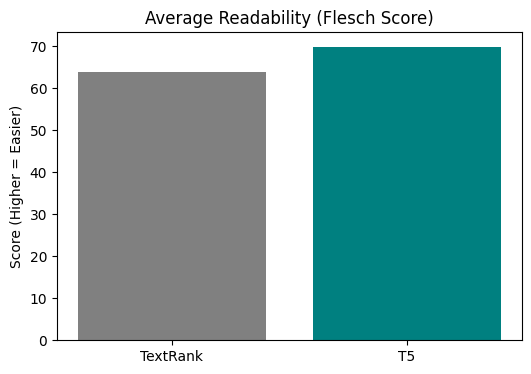

In [18]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
plt.bar(['TextRank','T5'],
        [df_sample['readability_textrank'].mean(), df_sample['readability_t5'].mean()],
        color=['gray','teal'])
plt.title("Average Readability (Flesch Score)")
plt.ylabel("Score (Higher = Easier)")
plt.show()